In [ ]:
import numpy as np
from names_dataset import NameDataset
from nn import Layer, MLP
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils import draw_dot
import pandas as pd
import torch

In [ ]:
df = pd.read_csv('data.csv', header=None)
first_col = df.iloc[:, 0]
first_col = first_col.str.lower()
first_col = first_col.to_list()
names = first_col

In [773]:
class Node:
    def __init__(self, data, _children=(), label='', _op=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data + other.data, (self, other), _op="+")

        def _backward():
            if self.data.ndim > other.data.ndim:  # self is a matrix, other is a vector (bias)
                self.grad += out.grad
                other.grad += out.grad.sum(axis=0)
            elif other.data.ndim > self.data.ndim:  # other is a matrix, self is a vector (bias)
                self.grad += out.grad.sum(axis=0)
                other.grad += out.grad
            else:  # Both are of the same dimensions
                self.grad += out.grad
                other.grad += out.grad

        out._backward = _backward
        return out
    
    def sum(self, axis=None, keepdims=False):
        out = Node(np.sum(self.data, axis=axis, keepdims=keepdims), (self,), _op="SUM")

        def _backward():
            self.grad += out.grad * np.ones_like(self.data)
        
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    
    def __radd__(self, other):
        return self + other
    
    def __rtruediv__(self, other):
        return other * self**-1

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __rmul__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data*other.data, (self, other), _op="*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        
        out._backward = _backward
        return out
    
    def mean(self):
        out = Node(np.mean(self.data), (self,), _op="MEAN")

        def _backward():
            self.grad += out.grad * np.ones_like(self.data) / self.data.size
        
        out._backward = _backward
        return out
    
    def reshape(self, out_shape):
        out = Node(self.data.reshape(-1, out_shape), (self,), _op="RESHAPE")

        def _backward():
            self.grad += np.reshape(out.grad, self.data.shape)

        out._backward = _backward
        return out
    
    def single_index_select(self, indices):
        indices = np.asarray(indices)
        selected_data = self.data[indices]
        
        out = Node(selected_data, (self,), _op="SINGLE_INDEX_SELECT")

        def _backward():
            grad = np.zeros_like(self.data)
            np.add.at(grad, indices, out.grad)
            self.grad += grad

        out._backward = _backward
        return out
    
    def __len__(self):
        return len(self.data)

    def max(self, axis=None, keepdims=False):
        out = Node(np.max(self.data, axis=axis, keepdims=keepdims), (self,), _op="MAX")

        def _backward():
            self.grad += out.grad * (self.data == out.data)
        
        out._backward = _backward
        return out
    
    def index_select(self, row_indices, col_indices):
        row_indices = np.asarray(row_indices)
        col_indices = np.asarray(col_indices)

        selected_data = self.data[row_indices, col_indices]
        out = Node(selected_data, (self,), _op="INDEX_SELECT")

        def _backward():
            grad = np.zeros_like(self.data)
            np.add.at(grad, (row_indices, col_indices), out.grad)
            self.grad += grad
        
        out._backward = _backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Node) else Node(float(other))
        return self * other**-1
    
    def __pow__(self, other):
        out = Node(self.data**other, (self,), _op="**")

        def _backward():
            self.grad += (other * self.data ** (other- 1))*out.grad
        
        out._backward = _backward
        return out
    
    
    
    def dot(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(np.dot(self.data, other.data), (self, other), _op="DOT")

        def _backward():
            self.grad += np.dot(out.grad, other.data.T)
            other.grad += np.dot(self.data.T, out.grad)
        
        out._backward = _backward
        return out
    
    def exp(self):
        out = Node(np.exp(self.data+1e-8), (self,), _op="EXP")

        def _backward():
            self.grad += out.grad * np.exp(self.data)
        
        out._backward = _backward
        return out

    def log(self):
        out = Node(np.log(self.data+1e-8), (self,), _op="LOG")

        def _backward():
            self.grad += out.grad * (1 / self.data)
        
        out._backward = _backward
        return out
    
    def relu(self):
        out = Node(np.maximum(self.data, 0), (self,), _op="RELU")

        def _backward():
            self.grad += out.grad if self.data > 0 else 0
        
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Node(np.tanh(self.data), (self,), _op="TANH")

        def _backward():
            self.grad += out.grad * (1 - np.tanh(self.data)**2)
        
        out._backward = _backward
        return out
    
    def shape(self):
        return self.data.shape
    
    def backward(self, clip_value=5):
        # topological order all of the children in the graph
        topo = []
        visited = []
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and applb the chain rule to get its gradient
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
            #if isinstance(v.grad, np.ndarray):
            #    np.clip(v.grad, -clip_value, clip_value, out=v.grad)
            
    def __repr__(self):
        return f"Node(data={self.data})"

In [732]:
unique_chars = set()
for name in names:
    unique_chars.update(set(name.lower()))
    if ' ' in name:
        print(name)
        names.remove(name)
        unique_chars.remove(' ')


unique_chars = sorted(list(unique_chars))
print(len(names))
print(len(unique_chars))
print(unique_chars)

S_to_I = {s:i+1 for i,s in enumerate(unique_chars)}
S_to_I['.'] = 0
I_to_S = {s:i for i,s in S_to_I.items()}

print(S_to_I)
print(I_to_S)

6782
26
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
bigrams = np.zeros((27, 27))
for name in many_names:
    chrs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chrs, chrs[1:]):
        idx1 = S_to_I[ch1]
        idx2 = S_to_I[ch2]
        bigrams[idx1, idx2] += 1

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(bigrams, cmap='Blues')

for i in range(27):
    for j in range(27):
        chstr = I_to_S[i] + I_to_S[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, bigrams[i, j].item(), ha='center', va='top', color='gray')

In [ ]:
P = bigrams / bigrams.sum(axis=1, keepdims=True)

In [ ]:
def sample_names(P):
    ix = 0
    name = ''
    while True:
        p = P[ix,:]
        ix = np.random.choice(27, p=p, size=1).item()
        name += I_to_S[ix]
        if ix == 0:
            break

    print(name)

for _ in range(10):
    sample_names(P)


In [ ]:
log_likelihood = 0
n = 0
for name in ['nomark']:
    chrs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chrs, chrs[1:]):
        idx1 = S_to_I[ch1]
        idx2 = S_to_I[ch2]
        prob = P[idx1, idx2]
        logprob = np.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'P({ch1}{ch2}) = {prob:.3f} -> logprob = {logprob:.3f}')

print(f'log_likelihood = {log_likelihood:.3f}')
neg_log_likelihood = -log_likelihood
print(f'neg_log_likelihood = {neg_log_likelihood:.3f}')
avg_neg_log_likelihood = neg_log_likelihood / n
print(f'avg_neg_log_likelihood = {avg_neg_log_likelihood:.3f}')

In [774]:
block_size = 3 

def build_dataset(words, numpy=True): 
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = S_to_I[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 

    if numpy:
        X = np.array(X)
        Y = np.array(Y)
    else:
        X = torch.tensor(X)
        Y = torch.tensor(Y)

    return X, Y

In [775]:
X, Y = build_dataset(names, numpy=True)

C = Node(np.random.randn(27, 2))
W1 = Node(np.random.randn(2*block_size, 100))*(5/3)/(np.sqrt(2*block_size))
b1 = Node(np.random.randn(100))*0
W2 = Node(np.random.randn(100,27))*0.01
b2 = Node(np.random.randn(27))*0

BATCH_SIZE = 128
params = [C, W1, b1, W2, b2]
nbr_params = sum(p.data.size for p in params)
print(f'number of parameters = {nbr_params}')


number of parameters = 3481


C:\Users\olofs\AppData\Local\Temp\ipykernel_12252\3517096309.py:139: RuntimeWarning: overflow encountered in exp
  out = Node(np.exp(self.data+1e-8), (self,), _op="EXP")
C:\Users\olofs\AppData\Local\Temp\ipykernel_12252\3517096309.py:57: RuntimeWarning: invalid value encountered in multiply
  out = Node(self.data*other.data, (self, other), _op="*")
C:\Users\olofs\AppData\Local\Temp\ipykernel_12252\3517096309.py:162: RuntimeWarning: divide by zero encountered in divide
  self.grad += out.grad * (1 / self.data)
C:\Users\olofs\AppData\Local\Temp\ipykernel_12252\3517096309.py:60: RuntimeWarning: invalid value encountered in multiply
  self.grad += out.grad * other.data
C:\Users\olofs\AppData\Local\Temp\ipykernel_12252\3517096309.py:61: RuntimeWarning: invalid value encountered in multiply
  other.grad += out.grad * self.data
C:\Users\olofs\AppData\Local\Temp\ipykernel_12252\3517096309.py:133: RuntimeWarning: invalid value encountered in multiply
  self.grad += (other * self.data ** (other-

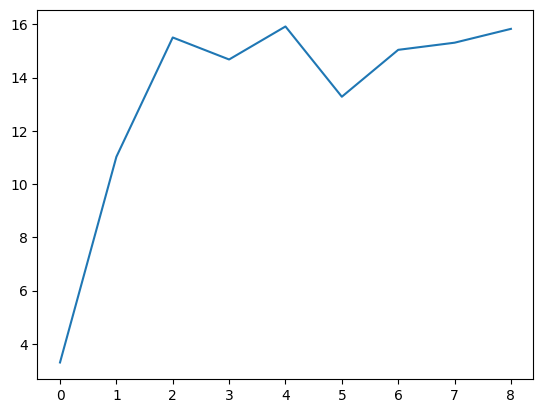

In [776]:
#TRAIN:
loses = []
for i in range(1000):

    # minibatch construct
    ix = np.random.randint(0, X.shape[0], size=BATCH_SIZE)

    #Forward pass
    emb = C.single_index_select(X[ix])
    h = (emb.reshape(2*block_size).dot(W1) + b1).tanh()
    logits =  (h.dot(W2) + b2)
    prob = logits.exp() / logits.exp().sum(axis=1, keepdims=True)
    loss = -prob.index_select((np.arange(len(X[ix]))), Y[ix]).log().mean()
   
    #Backward pass
    for p in params:
        p.grad = 0.0
    loss.backward()
   
    #Update
    for p in params:
        p.data += -10 * p.grad

    loses.append(loss.data)
    #if i % 1 == 0:
    #    print(f'loss = {loss.data:.3f}')


plt.plot(loses)

In [ ]:
X,Y = build_dataset(names, numpy=False)

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)*0.01
b1 = torch.randn(100, generator=g)*0
W2 = torch.randn((100, 27), generator=g)*0.01
b2 = torch.randn(27, generator=g)*0
parameters = [C, W1, b1, W2, b2]

print(f"Params: {sum(p.nelement() for p in parameters)}")
for p in parameters:
  p.requires_grad = True


In [ ]:
loses = []

for i in range(2000):
  
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  
  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
  logits = h @ W2 + b2 #
  loss = F.cross_entropy(logits, Y[ix]) 
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  for p in parameters:
    p.data += -0.1 * p.grad
  
  loses.append(loss.item())


plt.plot(loses)